In [81]:
from functions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


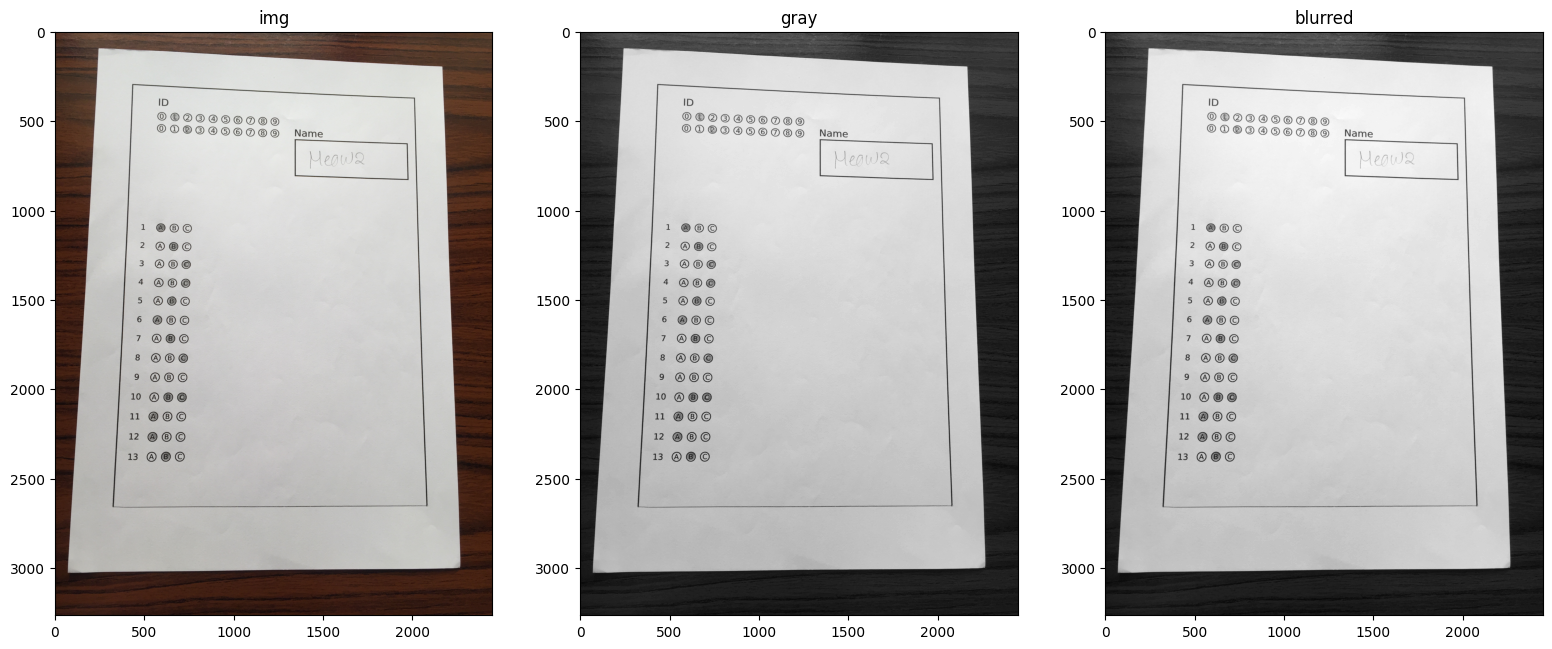

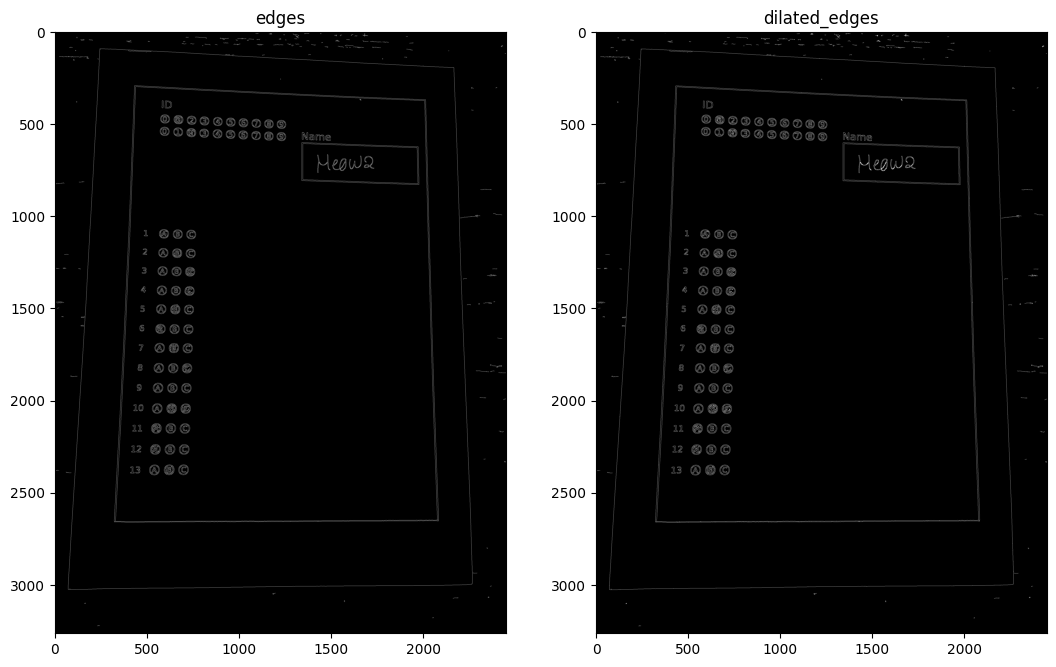

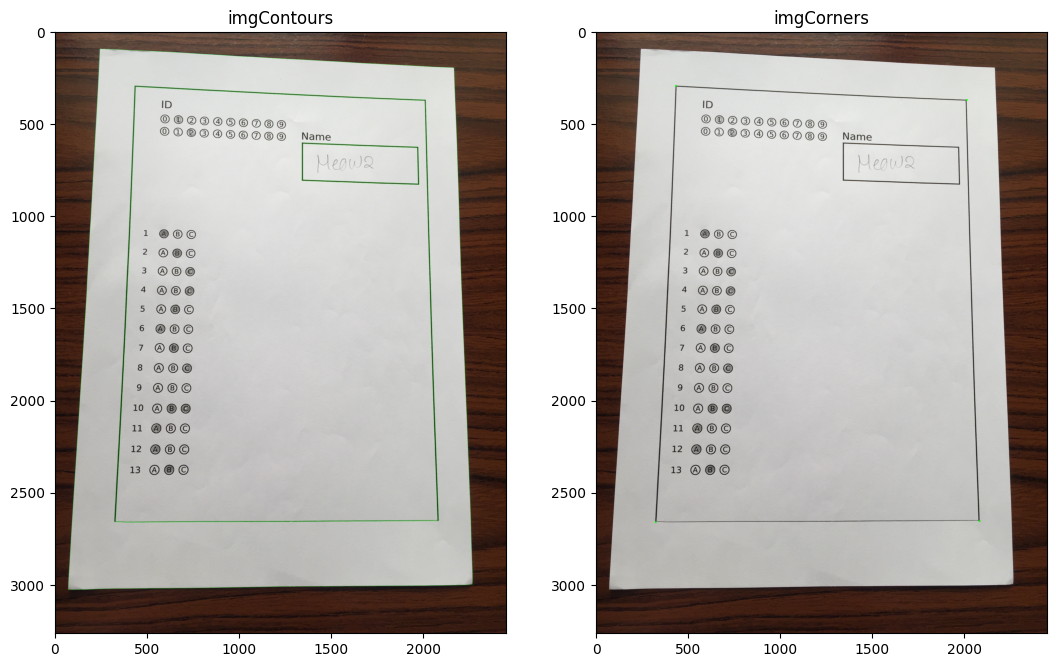

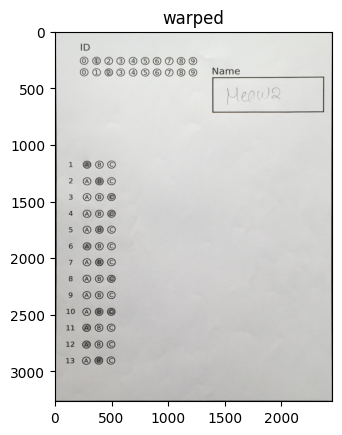

In [ ]:
img = cv2.imread('Bubble_sheet/13.jpg') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

warped_img = getPerspective(img)


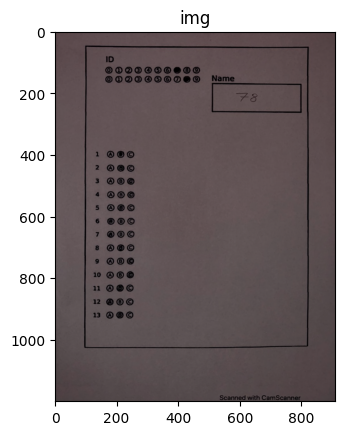

In [83]:
img = cv2.imread('pre2.jpg') 
def perspective_transform(img,binary,bubbleId=1):

    if img is None:
        print(f"Error: Unable to load the image.")
    else:
        # Convert the image to grayscale
        binary_image=0
        if binary==0:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Apply thresholding to create a binary image
            _, binary_image = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
        else :
            binary_image=img
        # cf.show_images([binary_image])
        # Find contours in the binary image
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour based on area
        # print(len(contours))
        largest_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

        # Get the four corners of the polygon
        corners = approx_polygon.reshape(-1, 2)
        corners = sorted(corners, key=lambda x: x[1])
        # Separate the sorted corners into top and bottom
        top_corners = sorted(corners[:2], key=lambda x: x[0])
        bottom_corners = sorted(corners[2:], key=lambda x: x[0])

        # Concatenate the sorted corners
        sorted_corners = np.concatenate([bottom_corners, top_corners])

        # Define the destination points for the perspective transformation
        dst_points = np.float32([[0, img.shape[0]], [img.shape[1], img.shape[0]], [0, 0], [img.shape[1], 0]])

        # Calculate the perspective transformation matrix
        matrix = cv2.getPerspectiveTransform(sorted_corners.astype(np.float32), dst_points)

        # Apply the perspective transformation to the image
        warped_img = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]))
        height,width=[warped_img.shape[0],warped_img.shape[1]]
        zoom=25
        zoom2=40 if bubbleId else 40
        zoomed_in_image = warped_img[zoom2:height-zoom2, zoom:width-zoom]
        return zoomed_in_image
    
img=cv2.imread('pre2.jpg', cv2.IMREAD_COLOR)

alpha = 0.7  # Contrast control (0.0-3.0)
beta = -50   # Brightness control (-100 to 100)
adjusted_img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
# cf.show_images([adjusted_img])
img=perspective_transform(adjusted_img,0)   
show_images([img], ["img"])     

In [84]:
import cv2

out_copy = np.copy(out)

# Convert to grayscale
gray = cv2.cvtColor(out_copy, cv2.COLOR_BGR2GRAY)

# Apply binary thresholding
_ , binary_image = cv2.threshold(gray, 160, 255, cv2.THRESH_BINARY)
binary_image = 255 - binary_image

# Find contours
contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw contours on the original image in red
cv2.drawContours(out_copy, contours, -1, (0, 0, 255), 2)  # Red color in BGR, thickness = 2

# Display the image with contours
show_images([binary_image, out_copy], ["binaryb image", 'resulted'])


NameError: name 'out' is not defined

In [ ]:
def perspective_transform(img):
    if img is None:
        print(f"Error: Unable to load the image.")
    else:
        # Convert the image to grayscale
        binary_image=0
        if binary==0:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Apply thresholding to create a binary image
            _, binary_image = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
        else :
            binary_image=img
        # cf.show_images([binary_image])
        # Find contours in the binary image
        contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Find the largest contour based on area
        # print(len(contours))
        largest_contour = max(contours, key=cv2.contourArea)
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_polygon = cv2.approxPolyDP(largest_contour, epsilon, True)

        # Get the four corners of the polygon
        corners = approx_polygon.reshape(-1, 2)
        corners = sorted(corners, key=lambda x: x[1])
        # Separate the sorted corners into top and bottom
        top_corners = sorted(corners[:2], key=lambda x: x[0])
        bottom_corners = sorted(corners[2:], key=lambda x: x[0])

        # Concatenate the sorted corners
        sorted_corners = np.concatenate([bottom_corners, top_corners])

        # Define the destination points for the perspective transformation
        dst_points = np.float32([[0, img.shape[0]], [img.shape[1], img.shape[0]], [0, 0], [img.shape[1], 0]])

        # Calculate the perspective transformation matrix
        matrix = cv2.getPerspectiveTransform(sorted_corners.astype(np.float32), dst_points)

        # Apply the perspective transformation to the image
        warped_img = cv2.warpPerspective(img, matrix, (img.shape[1], img.shape[0]))
        height,width=[warped_img.shape[0],warped_img.shape[1]]
        zoom=25
        zoom2=40 if bubbleId else 40
        zoomed_in_image = warped_img[zoom2:height-zoom2, zoom:width-zoom]
        return zoomed_in_image

In [ ]:

# alpha = 0.7  # Contrast control (0.0-3.0)
# beta = -50   # Brightness control (-100 to 100)
# img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
# show_images([img], ['adjusted_img'])





# # Find contours
# contours, _ = cv2.findContours(binary_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# # Draw contours on the original image in red
# cv2.drawContours(out, contours, -1, (0, 0, 255), 2)  # Red color in BGR, thickness = 2

# # Display the image with contours
# show_images([out], ['resulted'])